# Introduzione

Il seguente studio è stato svolto per interesse personale riguardo all'industria musicale. I dati a riguardo sono apparentemente riservati (a meno di previo pagamento), l'unica azienda di cui siamo riusciti a trovare i dati pubblicati liberamente è Spotify, che per quanto di dimensione limitata ci permettono di fare analisi sui loro guadagni e utenza mensile. Per curiosità personale abbiamo anche cercato dati riguardanti l'uso dell'applicazione pirata di Spotify, che permette di avere gratuitamente le funzioni da utente premium, per osservare come questa applicazione influenza utenti e guadagni dell'azienda.

## Domande di ricerca 
1) Da cosa vengono influenzati i guadagni di Spotify?
2) Quanto e in che modo l'uso della pirateria influenza i guadagni e l'utenza mensile?

### Terminologia
I dati vengono presentati dall'azienda utilizzando termini specifici:

* MAUs significa Monthly Active Users, indica l'utenza mensile (sia totale sia delle due categorie di utenza).
* Premium indica gli utenti abbonati al servizio e ciò a loro legato.
* Ad indica l'altro bacino di utenza, coloro che utlizzano il servizio gratuitamente con il supporto pubblicitario.

Nel corso dello studio utilizzeremo questa terminologia come presentata.

## Librerie utilizzate 

* Pandas per la gestione dei dataset.
* Matplotlib per la visualizzazione dei dati.
* Scipy.stats per le funzioni statistiche.
* Ruptures per la ricerca di changepoints.
* Statsmodels per i test di granger causality.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau
import ruptures as rpt 
from statsmodels.tsa.stattools import grangercausalitytests

In [3]:
data_path = './data/'

quarterly_df = pd.read_csv(f'{data_path}spoty.csv')
apk_df = pd.read_csv(f'{data_path}apk.csv', parse_dates=['Date'])

# Dataset

## Dati finanziari Spotify
È stato utilizzato un dataset creato a partire dai dati pubblicati da Spotify al link https://investors.spotify.com/financials/default.aspx, integrandoli con dati non pubblicati direttamente dall'azienda, ma presenti su un dataset di Kaggle (// TODO link kaggle).

## Download dell'apk
Per studiare il numero di download dell'apk si è fatto riferimento ai dati pubblicati da uno dei principali siti di download di software per Android https://www.apk4fun.com/history/9887/

## Manipolazioni sui dataframe
Per semplificare la visualizzazione dei dati, si inserisce nel dataframe relativo a Spotify una colonna aggiuntiva (denominata `Date`) per indicare insieme anno e trimestre (*quarter*).

In [4]:
quarterly_df['Date'] = quarterly_df['Year'].astype(str) + ' – Q' + quarterly_df['Quarter'].astype(str)
quarterly_df = quarterly_df.sort_values('Date')

## Aggregazioni per trimestre dei download dell'apk
Per confrontare i dati finanziari con i dati dell'apk, è necessario aggregare questi ultimi per trimestre (i dati sono forniti a intervalli variabili).

In [5]:
apk_df.set_index('Date', inplace=True)
apk_quarterly_df = apk_df['Downloads'].resample('QE').sum().to_frame()
apk_df.reset_index(inplace=True)
apk_quarterly_df.reset_index(inplace=True)

apk_quarterly_df['Year'] = apk_quarterly_df['Date'].dt.year 
apk_quarterly_df['Quarter'] = apk_quarterly_df['Date'].dt.quarter 
apk_quarterly_df['Date'] = apk_quarterly_df['Year'].astype(str) + ' – Q' + apk_quarterly_df['Quarter'].astype(str)

## Calcolo MAUs marginali
I download dell'apk possono essere visti, al netto di download multipli da parte di uno stesso utente, come indicativi dell'incremento degli utenti che ne usufruiscono nel corso del tempo, piuttosto che indicativi del numero totale di fruitori. Per questo motivo, può avere più senso confrontare questo valore con l'incremento dei MAUs in ogni trimestre, invece che con i MAUs stessi.

Si calcolano di seguito i MAUs (MAUs, Premium MAUs, Ad MAUs) marginali.

In [6]:
quarterly_df['Marginal MAUs'] = quarterly_df['MAUs'].diff()
quarterly_df['Marginal Premium MAUs'] = quarterly_df['Premium MAUs'].diff()
quarterly_df['Marginal Ad MAUs'] = quarterly_df['Ad MAUs'].diff()

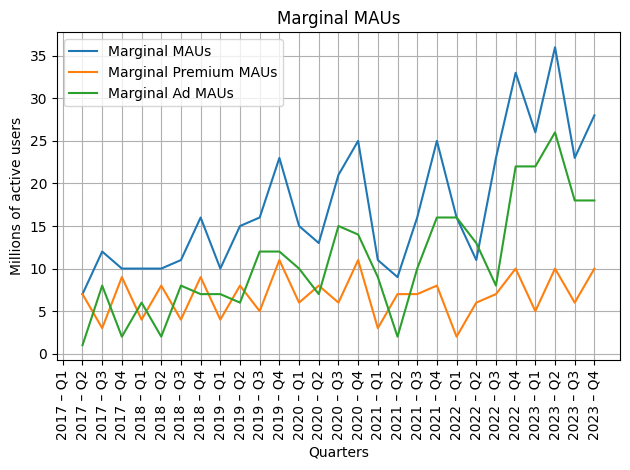

In [7]:
plt.figure()
plt.plot(quarterly_df['Date'], quarterly_df['Marginal MAUs'], label='Marginal MAUs')
plt.plot(quarterly_df['Date'], quarterly_df['Marginal Premium MAUs'], label='Marginal Premium MAUs')
plt.plot(quarterly_df['Date'], quarterly_df['Marginal Ad MAUs'], label='Marginal Ad MAUs')
plt.xticks(rotation=90)
plt.title('Marginal MAUs')
plt.xlabel('Quarters')
plt.ylabel('Millions of active users')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

## Visualizzazione di alcuni dati
Si riportano qui di seguito alcune visualizzazioni dei dati presenti nel dataset, al fine di offrire una panoramica su alcuni aspetti rilevanti per la successiva analisi.

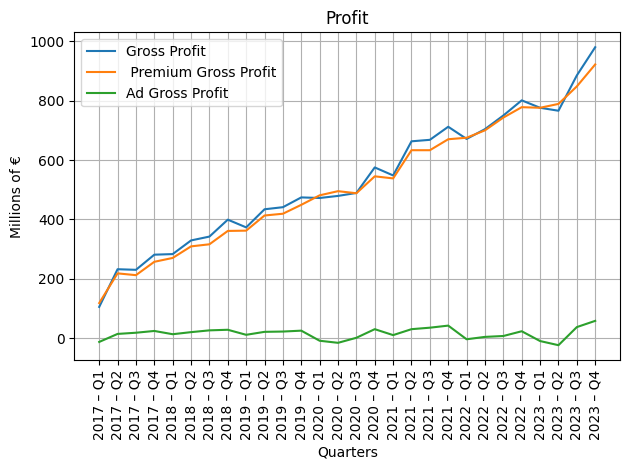

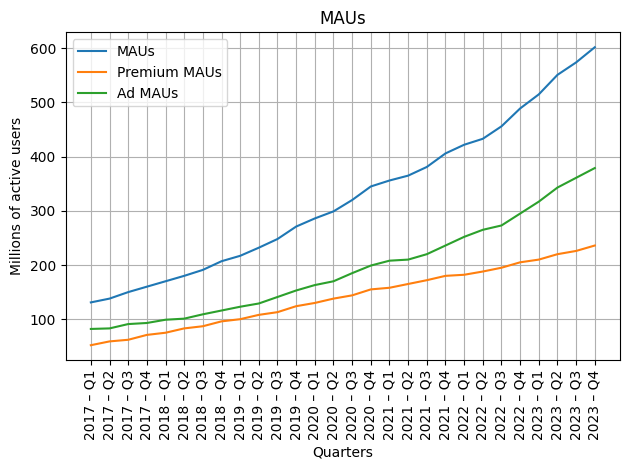

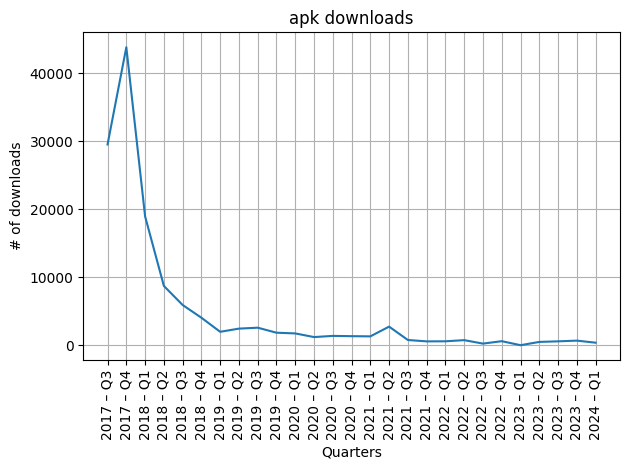

In [8]:
plt.figure()
plt.plot(quarterly_df['Date'], quarterly_df['Gross Profit'], label='Gross Profit')
plt.plot(quarterly_df['Date'], quarterly_df['Premium Gross Profit'], label=' Premium Gross Profit')
plt.plot(quarterly_df['Date'], quarterly_df['Ad Gross Profit'], label='Ad Gross Profit')
plt.xticks(rotation=90)
plt.title('Profit')
plt.xlabel('Quarters')
plt.ylabel('Millions of €')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

plt.figure()
plt.plot(quarterly_df['Date'], quarterly_df['MAUs'], label='MAUs')
plt.plot(quarterly_df['Date'], quarterly_df['Premium MAUs'], label='Premium MAUs')
plt.plot(quarterly_df['Date'], quarterly_df['Ad MAUs'], label='Ad MAUs')
plt.xticks(rotation=90)
plt.title('MAUs')
plt.xlabel('Quarters')
plt.ylabel('Millions of active users')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

plt.figure()
plt.plot(apk_quarterly_df['Date'], apk_quarterly_df['Downloads'])

plt.xticks(rotation=90)
plt.title('apk downloads')
plt.xlabel('Quarters')
plt.ylabel('# of downloads')
plt.tight_layout()
plt.grid()
plt.show()


# Metodo proposto

## Coefficienti di correlazione

Per studiare le correlazioni tra le varie serie in esame, si è ricorso all'utilizzo di tre metriche, implementate dalla libreria `scipy`. Si riportano di seguito le loro definizioni.

### Pearson
Quantifica la correlazione **lineare** tra due variabili. È definita come il rapporto tra la covarianza delle variabili e il prodotto delle loro deviazioni standard, e assume dunque valori tra -1 e 1. 

\begin{equation}
    \rho_{X,Y} = \frac{\text{cov}(X, Y)}{\sigma_{X}\sigma_{Y}}
\end{equation}


### Spearman
Equivale alla correlazione di Pearson calcolata sulle variabili i cui valori sono convertiti nei rispettivi ranghi (ossia i valori vengono ordinati e sostituiti dal valore della loro posizione).
Il coefficiente di Spearman è simile al coefficiente di Pearson, ma è meno sensibile a eventuali outliers e permette di rilevare correlazioni di tipo **non lineare**.

\begin{equation}
    \rho_{R(X),R(Y)} = \frac{\text{cov}(R(X), R(Y))}{\sigma_{R(X)}\sigma_{R(Y)}}
\end{equation}

## Calcolo dei changepoint

Un changepoint è un punto della serie in cui si verifica una variazione signifcativa nel comportamento o nelle proprietà dei dati (media, varianza o altre caratteristiche).

In termini matematici, il calcolo dei changepoint in ruptures si basa su un modello statistico che cerca di suddividere una serie temporale $X = \{x_1, x_2, ..., x_n\}$ in segmenti omogenei tra loro. Ogni segmento è caratterizzato da una distribuzione statistica diversa o da un insieme di parametri.

L'obiettivo è trovare il numero ottimale di segmenti e i punti in cui avviene il cambiamento. Questo può essere formulato come un problema di ottimizzazione che cerca di minimizzare una funzione di costo. 

La funzione di costo utilizzata dal modello `rbf` di Ruptures è la seguente:

\begin{equation}
    c_{rbf}(y_{a..b}) = (b - a) - \frac{1}{b - a} \sum_{s,t = a + 1}^{b} \exp(-\gamma ||y_{s} - y_{t}||^{2}).
\end{equation}

Questa formula è utilizzata per il calcolo del criterio quantitativo $ \mathcal{V}(\mathcal{T}, y) $ (dove $ \mathcal{T} $ è la segmentazione della serie di partenza $ y $):

\begin{equation}
    \mathcal{V}(\mathcal{T}, y) = \sum_{k = 0}^{K} c_{rbf}(y_{t_{k}..t_{k+1}}).
\end{equation}

Quando il numero di changepoint da trovare non è noto a priori, per la ricerca della miglior segmentazione possibile bisogna trovare il minimo del critario quantitativo, più un valore di penalità, secondo la formula:

\begin{equation}
    \min_{\mathcal{T}} \mathcal{V}(\mathcal{T}, y) + \text{pen}(\mathcal{T}),
\end{equation}

dove la penalità è un valore che quantifica il trade-off tra la complessità e la bontà della soluzione; in altre parole, una penalità più alta porta a una precisione maggiore, ma con una quantità minore di changepoint rilevati.

L'algoritmo PELT (Pruned Exact Linear Time) minimizza la funzione $ \mathcal{V}(\mathcal{T}, y) $ riducendo lo spazio di ricerca attraverso un'euristica di pruning; in particolare, dati due punti della serie $t$ e $s$ tali che $t<s<T$, il punto $ t $ può essere sicuramente scartato se vale la seguente relazione:

\begin{equation}
    [\min_{\mathcal{T}} \mathcal{V}(\mathcal{T}, y_{0..t}) + \text{pen}(\mathcal{T}) ] + c_{rbf}(y_{t..s}) \geq [\min_{\mathcal{T}} \mathcal{V}(\mathcal{T}, y_{0..s}) + \text{pen}(\mathcal{T}) ].
\end{equation}

# Risultati sperimentali

## Fonti di guadagno di Spotify

### Percentuale dei guadagni sui ricavi

Per capire quanto sono effettivamente rilevanti le due componenti del guadagno (Premium Gross Profit e Ad Gross Profit), vengono rapportate alle entrate lorde, assieme a Gross Profit come confronto.

In [9]:
quarterly_df['Profit Percentage'] = quarterly_df['Gross Profit'] / quarterly_df['Total Revenue'] * 100
quarterly_df['Premium Profit Percentage'] = quarterly_df['Premium Gross Profit'] / quarterly_df['Total Revenue'] * 100
quarterly_df['Ad Profit Percentage'] = quarterly_df['Ad Gross Profit'] / quarterly_df['Total Revenue'] * 100

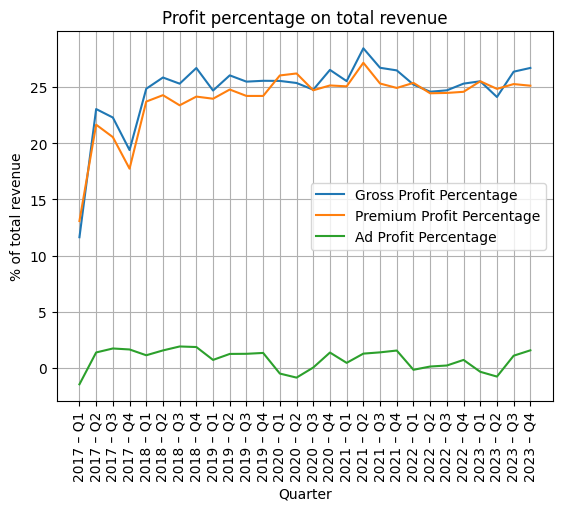

In [10]:
plt.figure()
plt.plot(quarterly_df['Date'], quarterly_df['Profit Percentage'], label='Gross Profit Percentage')
plt.plot(quarterly_df['Date'], quarterly_df['Premium Profit Percentage'], label='Premium Profit Percentage')
plt.plot(quarterly_df['Date'], quarterly_df['Ad Profit Percentage'], label='Ad Profit Percentage')

plt.title('Profit percentage on total revenue')
plt.xlabel('Quarter')
plt.ylabel('% of total revenue')
plt.xticks(rotation=90)
plt.grid()
plt.legend()
plt.show()

Si può facilmente notare che il guadagno viene guidato dall'utenza premium, mentre il servizio ad provoca alle volte anche delle perdite. 

### Correlazione tra guadagni e MAUs

Procediamo a verificare la presenza di correlazioni fra l'andamento dei i guadagni e dei due bacini di utenza.

In [38]:
pearson_corr_profit_maus, pearson_profit_maus_pvalue = pearsonr(quarterly_df['Premium MAUs'], quarterly_df['Gross Profit'])
print(f'Pearson correlation: {pearson_corr_profit_maus}')
print(f'p-value: {pearson_profit_maus_pvalue}')
print('\n')

spearman_corr_profit_maus, spearman_profit_maus_pvalue = spearmanr(quarterly_df['Premium MAUs'], quarterly_df['Gross Profit'])
print(f'Spearman correlation: {spearman_corr_profit_maus}')
print(f'p-value: {spearman_profit_maus_pvalue}')

Pearson correlation: 0.9865791719644258
p-value: 5.397965670764151e-22


Spearman correlation: 0.9939792008757526
p-value: 1.6771999002826718e-26


In [37]:
pearson_corr_profit_maus, pearson_profit_maus_pvalue = pearsonr(quarterly_df['Ad MAUs'], quarterly_df['Gross Profit'])
print(f'Pearson correlation: {pearson_corr_profit_maus}')
print(f'p-value: {pearson_profit_maus_pvalue}')
print('\n')

spearman_corr_profit_maus, spearman_profit_maus_pvalue = spearmanr(quarterly_df['Ad MAUs'], quarterly_df['Gross Profit'])
print(f'Spearman correlation: {spearman_corr_profit_maus}')
print(f'p-value: {spearman_profit_maus_pvalue}')

Pearson correlation: 0.9678454927709811
p-value: 4.1634908732952465e-17


Spearman correlation: 0.9939792008757526
p-value: 1.6771999002826718e-26


Come prevedibile il numero di utenti attivi mensilmente è correlato direttamente con i guadagni dell'azienda. In particolare, nonostante il profitto dato dall'utenza ad sia qualche volta in perdita, la sola presenza di utenti correla in maniera positiva con il profitto. 

### Calcolo dei changepoint

Per indagare ulteriormente la presenza di correlazione procediamo alla ricerca di changepoints nelle varie serie.

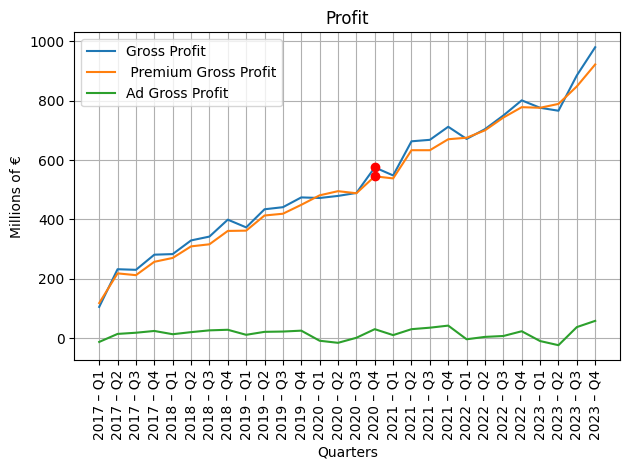

In [13]:
profit_labels = ['Gross Profit', 'Premium Gross Profit', 'Ad Gross Profit']

changepoints = dict()
for feature in profit_labels:
    algo = rpt.Pelt(model='rbf').fit(quarterly_df[feature].values)
    result = algo.predict(pen=6) 
    changepoints[feature] = filter(lambda x: x < quarterly_df[feature].count(), result)

plt.figure()
plt.plot(quarterly_df['Date'], quarterly_df['Gross Profit'], label='Gross Profit')
plt.plot(quarterly_df['Date'], quarterly_df['Premium Gross Profit'], label=' Premium Gross Profit')
plt.plot(quarterly_df['Date'], quarterly_df['Ad Gross Profit'], label='Ad Gross Profit')


for label in profit_labels:
    for point in changepoints[label]:
        plt.plot(point, quarterly_df[label].loc[point], 'ro')


plt.xticks(rotation=90)
plt.title('Profit')
plt.xlabel('Quarters')
plt.ylabel('Millions of €')
plt.legend()
plt.tight_layout()
plt.grid()

plt.show()


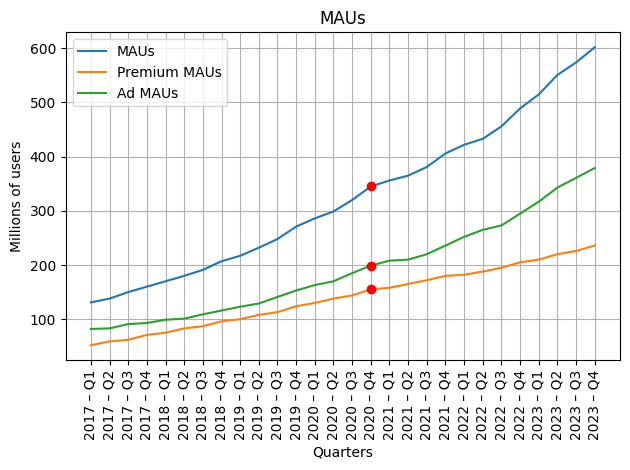

In [14]:
maus_labels = ['MAUs', 'Premium MAUs', 'Ad MAUs']

changepoints = dict()
for feature in maus_labels:
    algo = rpt.Pelt(model='rbf').fit(quarterly_df[feature].values)
    result = algo.predict(pen=6) 
    changepoints[feature] = filter(lambda x: x < quarterly_df[feature].count(), result)

plt.figure()

for label in maus_labels:
    plt.plot(quarterly_df['Date'], quarterly_df[label], label=label)


for label in maus_labels:
    for point in changepoints[label]:
        plt.plot(point, quarterly_df[label].loc[point], 'ro')
        


plt.xticks(rotation=90)
plt.title('MAUs')
plt.xlabel('Quarters')
plt.ylabel('Millions of users')
plt.legend()
plt.tight_layout()
plt.grid()

plt.show()

I changepoints riportati corrispondono nelle varie serie (a meno di ad profit) al quarto trimestre del 2020, appena dopo lo scoppio della pandemia covid-19 e relativi lockdowns.
Si nota come il profitto dato dall'utenza ad non presenti changepoints.

Potremmo quindi ragionevolmente assumere che i guadagni dell'azienda siano direttamente correlati alla presenza di utenti attivi. In particolare, data la percentuale di impatto sui guadagni, sembrerebbe che sia l'utenza premium a guidare la quasi totalità dei guadagni.

### Granger causality di premium/ad MAUS su gross profit

Per confermare l'influenza degli utenti (sia premium sia ad) sui guadagni procediamo ad effettuare dei test di granger causality.

In [15]:
granger_premium_maus = grangercausalitytests(quarterly_df[['Gross Profit', 'Premium MAUs']], maxlag=1)
print(granger_premium_maus)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.4191 , p=0.0006  , df_denom=24, df_num=1
ssr based chi2 test:   chi2=17.3464 , p=0.0000  , df=1
likelihood ratio test: chi2=13.3973 , p=0.0003  , df=1
parameter F test:         F=15.4191 , p=0.0006  , df_denom=24, df_num=1
{1: ({'ssr_ftest': (15.419059399836522, 0.0006339831017818883, 24.0, 1), 'ssr_chi2test': (17.346441824816086, 3.1148089875903534e-05, 1), 'lrtest': (13.397281472795328, 0.0002519892500313163, 1), 'params_ftest': (15.419059399836515, 0.0006339831017818898, 24.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x14a41deb0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x14f8d8df0>, array([[0., 1., 0.]])])}


In [16]:
granger_ad_maus = grangercausalitytests(quarterly_df[['Gross Profit', 'Ad MAUs']], maxlag=1)
print(granger_ad_maus)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.1532 , p=0.0002  , df_denom=24, df_num=1
ssr based chi2 test:   chi2=21.5474 , p=0.0000  , df=1
likelihood ratio test: chi2=15.8410 , p=0.0001  , df=1
parameter F test:         F=19.1532 , p=0.0002  , df_denom=24, df_num=1
{1: ({'ssr_ftest': (19.153235919794586, 0.0002028042869717894, 24.0, 1), 'ssr_chi2test': (21.54739040976891, 3.451920740421288e-06, 1), 'lrtest': (15.840996571364542, 6.889354515106239e-05, 1), 'params_ftest': (19.153235919794604, 0.00020280428697178838, 24.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x14f8d8e50>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x14a41df70>, array([[0., 1., 0.]])])}


Come mostrato dai risultati la presenza di utenti attivi è direttamente causa dei guadagni dell'azienda. È da notare come anche gli utenti ad contribuiscano all'incremento dei guadagni nonostante la loro presenza a livello economico (ad profit) non sia molto rilevante per i guadagni totali.

In [17]:
granger_ad_profit_maus = grangercausalitytests(quarterly_df[['Ad Gross Profit', 'Ad MAUs']], maxlag=1)
print(granger_ad_profit_maus)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0725  , p=0.7901  , df_denom=24, df_num=1
ssr based chi2 test:   chi2=0.0815  , p=0.7752  , df=1
likelihood ratio test: chi2=0.0814  , p=0.7754  , df=1
parameter F test:         F=0.0725  , p=0.7901  , df_denom=24, df_num=1
{1: ({'ssr_ftest': (0.07248419915100783, 0.7900546461523481, 24.0, 1), 'ssr_chi2test': (0.0815447240448838, 0.7752148613156824, 1), 'lrtest': (0.08142183175314699, 0.7753797559891124, 1), 'params_ftest': (0.07248419915099863, 0.7900546461523594, 24.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x14f8d8550>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x14f8d8370>, array([[0., 1., 0.]])])}


Questo ulteriore test non ci permettono di rigettare l'ipotesi nulla (ossia che gli Ad MAUs ad non influenzino i guadagni relativi al piano ad).

Alla luce dei test effettuati, sembrerebbe che la fonte principale dei guadagni di Spotify sia l'utenza Premium, sebbene anche l'utenza ad contribuisca ai guadagni anche se talvolta in perdita.

## Quanto l'apk influenza i guadagni di Spotify

Siccome il guadagno viene guidato dalle vendite di licenze premium per l'utilizzo degli applicativi, è interessante ora osservare come la presenza di una versione piratata dell'applicazione possa influenzare il comportamento degli utenti e di conseguenza i guadagni.

L'applicazione piratata, di seguito indicata come apk, permette di avere quasi interamente a disposizione tutte le funzionalità di un utente premium (a meno di connessione fra più dispositivi). È logico pensare che questo possa influenzare la decisione di un utente che desidera le funzionalità premium e non ne ritiene necessario il pagamento, o semplicemente anche un utente ad che trova più comodo utilizzare l'apk senza necessariamente volere tutte le funzioni aggiuntive (quindi solo per evitare le pubblicità).

Per procedere con le analisi è innanzitutto necessario troncare le due serie, per poterle confrontare nello stesso intervallo temporale (2017Q3 – 2023Q4).

In [21]:
start_date = max(quarterly_df['Date'].min(), apk_quarterly_df['Date'].min())
end_date = min(quarterly_df['Date'].max(), apk_quarterly_df['Date'].max())

trunc_quarterly_df = quarterly_df[
    (quarterly_df['Date'] >= start_date) &
    (quarterly_df['Date'] <= end_date)
].reset_index()

trunc_apk_quarterly_df = apk_quarterly_df[
    (apk_quarterly_df['Date'] >= start_date) &
    (apk_quarterly_df['Date'] <= end_date)
].reset_index()

### Correlazione tra Premium MAUs e download apk

Per prima cosa verifichiamo che ci sia effettiva correlazione fra il download dell'apk e l'utenza totale, premium e ad.

In [39]:
pearson_corr_maus, pearson_pvalue = pearsonr(trunc_quarterly_df['MAUs'], trunc_apk_quarterly_df['Downloads'])
print(f'Pearson correlation: {pearson_corr_maus}')
print(f'p-value: {pearson_pvalue}')
print('\n')

spearman_corr_maus, spearman_pvalue = spearmanr(trunc_quarterly_df['MAUs'], trunc_apk_quarterly_df['Downloads'])
print(f'Spearman correlation: {spearman_corr_maus}')
print(f'p-value: {spearman_pvalue}')

Pearson correlation: -0.5643699439816536
p-value: 0.0026705638963746858


Spearman correlation: -0.9206837606837606
p-value: 2.7168222882982103e-11


In [40]:
pearson_corr_maus, pearson_pvalue = pearsonr(trunc_quarterly_df['Premium MAUs'], trunc_apk_quarterly_df['Downloads'])
print(f'Pearson correlation: {pearson_corr_maus}')
print(f'p-value: {pearson_pvalue}')
print('\n')

spearman_corr_maus, spearman_pvalue = spearmanr(trunc_quarterly_df['Premium MAUs'], trunc_apk_quarterly_df['Downloads'])
print(f'Spearman correlation: {spearman_corr_maus}')
print(f'p-value: {spearman_pvalue}')

Pearson correlation: -0.6223810216218667
p-value: 0.0006859359176054387


Spearman correlation: -0.9206837606837606
p-value: 2.7168222882982103e-11


In [41]:
pearson_corr_maus, pearson_pvalue = pearsonr(trunc_quarterly_df['Ad MAUs'], trunc_apk_quarterly_df['Downloads'])
print(f'Pearson correlation: {pearson_corr_maus}')
print(f'p-value: {pearson_pvalue}')
print('\n')

spearman_corr_maus, spearman_pvalue = spearmanr(trunc_quarterly_df['Ad MAUs'], trunc_apk_quarterly_df['Downloads'])
print(f'Spearman correlation: {spearman_corr_maus}')
print(f'p-value: {spearman_pvalue}')

Pearson correlation: -0.5290620953767572
p-value: 0.005452090172946295


Spearman correlation: -0.9206837606837606
p-value: 2.7168222882982103e-11


Queste correlazioni mostrano come effettivamente una diminuzione dei download dell'apk correla con l'aumento di utenza 
"normale", e come dimostrato in precendenza a un corrispondente aumento di guadagni totali.

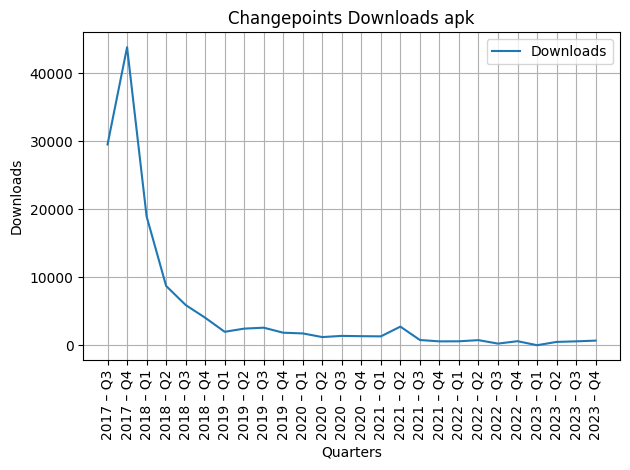

In [25]:
changepoints = dict()
algo = rpt.Pelt(model='rbf').fit(trunc_apk_quarterly_df['Downloads'].values)
result = algo.predict(pen=6) 
changepoints['Downloads'] = filter(lambda x: x < trunc_apk_quarterly_df['Downloads'].count(), result)

plt.figure()
plt.plot(trunc_apk_quarterly_df['Date'], trunc_apk_quarterly_df['Downloads'], label='Downloads')


for point in changepoints['Downloads']:
    plt.plot(point, trunc_apk_quarterly_df['Downloads'].loc[point], 'ro')


plt.xticks(rotation=90)
plt.title('Changepoints Downloads apk')
plt.xlabel('Quarters')
plt.ylabel('Downloads')
plt.legend()
plt.tight_layout()
plt.grid()

plt.show()

L'assenza di changepoints fa però sospettare che, nonostante le correlazioni, non ci sia una causalità fra l'apk e l'utenza. Procediamo quindi ad effettuare analisi più accurate.

### Correlazione tra Premium MAUs marginali e download apk

A differenza dei premium MAUs, il numero di download dell'apk non indica l'utenza attiva mensilmente sull'applicazione ma una serie di incrementi (a meno di download multipli da parte dello stesso utente). È ragionevole quindi andarli a confrontare con gli utenti mensili marginali.

In [44]:
pearson_corr_marginal_premium_maus, pearson_marginal_premium_pvalue = pearsonr(trunc_quarterly_df['Marginal Premium MAUs'], trunc_apk_quarterly_df['Downloads'])
print(f'Pearson correlation: {pearson_corr_marginal_premium_maus}')
print(f'p-value: {pearson_marginal_premium_pvalue}')
print('\n')

spearman_corr_marginal_premium_maus, spearman_marginal_premium_pvalue = spearmanr(trunc_quarterly_df['Marginal Premium MAUs'], trunc_apk_quarterly_df['Downloads'])
print(f'Spearman correlation: {spearman_corr_marginal_premium_maus}')
print(f'p-value: {spearman_marginal_premium_pvalue}')

Pearson correlation: -0.09670169273907739
p-value: 0.6383997581432619


Spearman correlation: -0.1228093718374692
p-value: 0.5500538723379269


In [45]:
pearson_corr_marginal_ad_maus, pearson_marginal_ad_pvalue = pearsonr(trunc_quarterly_df['Marginal Ad MAUs'], trunc_apk_quarterly_df['Downloads'])
print(f'Pearson correlation: {pearson_corr_marginal_ad_maus}')
print(f'p-value: {pearson_marginal_ad_pvalue}')
print('\n')

spearman_corr_marginal_ad_maus, spearman_marginal_ad_pvalue = spearmanr(trunc_quarterly_df['Marginal Ad MAUs'], trunc_apk_quarterly_df['Downloads'])
print(f'Spearman correlation: {spearman_corr_marginal_ad_maus}')
print(f'p-value: {spearman_marginal_ad_pvalue}')


Pearson correlation: -0.4617545055470043
p-value: 0.01756483902456059


Spearman correlation: -0.7750379850624468
p-value: 3.336374284666813e-06


In questo caso non viene riportata una correlazione rilevante con gli utenti premium, più significativa però con gli utenti ad. 

C'è quindi una correlazione inversa (di tipo non lineare) fra i download dell'apk e la variazione degli utenti ad; in altre parole un aumento dei download dell'apk è (debolmente) correlato con una diminuzione degli utenti ad.

### Granger causality di download apk su MAUs marginali

Per confermare l'influenza dei download sulla crescita di utenti procediamo ad effettuare i test di granger causality.

In [31]:
apk_premium_maus_marginal = pd.DataFrame()
apk_premium_maus_marginal['Downloads'] = trunc_apk_quarterly_df['Downloads']
apk_premium_maus_marginal['Marginal Premium MAUs'] = trunc_quarterly_df['Marginal Premium MAUs']
granger_apk_maus_marginal = grangercausalitytests(apk_premium_maus_marginal[['Marginal Premium MAUs', 'Downloads']], maxlag=1)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8566  , p=0.3647  , df_denom=22, df_num=1
ssr based chi2 test:   chi2=0.9734  , p=0.3238  , df=1
likelihood ratio test: chi2=0.9549  , p=0.3285  , df=1
parameter F test:         F=0.8566  , p=0.3647  , df_denom=22, df_num=1


In [32]:
apk_ad_maus_marginal = pd.DataFrame()
apk_ad_maus_marginal['Downloads'] = trunc_apk_quarterly_df['Downloads']
apk_ad_maus_marginal['Marginal Ad MAUs'] = trunc_quarterly_df['Marginal Ad MAUs']
granger_apk_maus_marginal = grangercausalitytests(apk_ad_maus_marginal[['Marginal Ad MAUs', 'Downloads']], maxlag=1)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9858  , p=0.1728  , df_denom=22, df_num=1
ssr based chi2 test:   chi2=2.2566  , p=0.1330  , df=1
likelihood ratio test: chi2=2.1605  , p=0.1416  , df=1
parameter F test:         F=1.9858  , p=0.1728  , df_denom=22, df_num=1


I test riportano dei p-value di molto superiori al 5%: questo non ci permette di escludere che i download non influenzino la crescita di utenza, possiamo quindi formulare le nostre conclusioni solo alla luce delle correlazioni mostrate in precedenza.

# Conclusioni e Osservazioni

Questo suggerisce che variazioni dei download dell'apk non comportino particolari cambiamenti nell'utenza premium, e che coloro che scaricano l'apk sarebbero potenzialmente utenti ad comunque non paganti.